# Graph-convolutional auto-encoder: BlogCatalog

## Imports and setup

In [1]:
import time
import random
import csv
from collections import defaultdict

import numpy as np
import scipy as sp
import scipy.stats
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sb
import networkx as nx

import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from keras.utils.vis_utils import model_to_dot

from progressbar import ProgressBar
from IPython.display import SVG, HTML, display

from nw2vec import ae
from nw2vec import utils
from nw2vec import codecs
from nw2vec import layers
from nw2vec import viz
from nw2vec import batching

Using TensorFlow backend.


### Model drawing routines

In [2]:
def plot_ξ_distribution(g, q_model, adj, features, batches_gen):
    #g, l, k = glk
    #palette = np.concatenate([np.array(sb.color_palette(n_colors=l)),
    #                          .5 * np.ones((l, 1))],
    #                         axis=1)
    #communities = ([[i] for i in range(l)] * np.ones((l, k), dtype=np.int32)).reshape(-1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))#, sharex=True, sharey=True)

    x, _, feeds = next(batches_gen(q_model, features, adj, adj.shape[0], adj.shape[0], None))
    q_pred = q_model.predict_on_fed_batch(x, feeds=feeds)

    # KDE plots
    #q_pred_ξ_sample = K.eval(codecs.Gaussian(q_pred).stochastic_value(100))
    #for i in range(l):
    #    x = q_pred_ξ_sample[i * k:(i + 1) * k, :, 0].flatten()
    #    y = q_pred_ξ_sample[i * k:(i + 1) * k, :, 1].flatten()
    #    sb.kdeplot(x, y, cmap=sb.light_palette(palette[i], as_cmap=True),
    #               shade=True, shade_lowest=False, ax=ax1)
    #ax1.set_title(r'$\xi$ density for each community (flat nodes+sampling)')
    
    # μ plots
    q_pred_μ = q_pred[:, :2].T
    #ax2.scatter(q_pred_μ[0], q_pred_μ[1], s=250)#, c=palette[communities])
    sb.kdeplot(q_pred_μ[0], q_pred_μ[1], ax=ax2)
    #for i, (x, y) in enumerate(q_pred_μ.T):
    #    ax2.text(x, y, str(i), ha='center', va='center', color='white')
    ax2.set_title(r'$\mu = \left<\xi\right>$ for each node')
    
    # Box representing the μ plots in the KDE plots
    #ax1.hlines(ax2.get_ylim(), *ax2.get_xlim(), colors='lightgrey')
    #ax1.vlines(ax2.get_xlim(), *ax2.get_ylim(), colors='lightgrey')

## Load data

In [3]:
### Get the full list of nodes and groups ###

# nodes
nodes = []
with open('data/BlogCatalog-dataset/data/nodes.csv') as csvfile:
    reader = csv.reader(csvfile)
    nodes = [int(row[0]) for row in reader]
assert len(nodes) == len(set(nodes))
nodes = set(nodes)

# groups
groups = []
with open('data/BlogCatalog-dataset/data/groups.csv') as csvfile:
    reader = csv.reader(csvfile)
    groups = [int(row[0]) for row in reader]
assert len(groups) == len(set(groups))
groups = set(groups)


### Generate graph from edges and node data ###

# Read edges.csv and make a network out of it
edges = defaultdict(list)
with open('data/BlogCatalog-dataset/data/edges.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        edges[int(row[0])].append(int(row[1]))

g = nx.from_dict_of_lists(edges, create_using=nx.Graph())

# Read group-edges.csv and add that info to each node
group_edges = defaultdict(list)
with open('data/BlogCatalog-dataset/data/group-edges.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        group_edges[int(row[0])].append(int(row[1]))

for node, data in g.nodes.items():
    data['groups'] = group_edges[node]


### Sanity checks ###
assert set(g.nodes) == nodes
assert set().union(*[groups for _, groups in g.nodes(data='groups')]) == groups

## Set node labels

In [4]:
labels = np.zeros((len(nodes), len(groups)))
nodes_offset = min(nodes)
groups_offset = min(groups)
for n, data in g.nodes.items():
    labels[n - nodes_offset, np.array(data['groups']) - groups_offset] = 1

## Build the VAE

In [5]:
# VAE Parameters
n_nodes = len(nodes)
adj = np.array(nx.adjacency_matrix(g).todense().astype(np.float32))

n_ξ_samples = 5
dim_data, dim_l1, dim_ξ = len(groups), 10, 2
dims = (dim_data, dim_l1, dim_ξ)
use_bias = False

# Actual VAE
q_model, q_codecs = ae.build_q(dims, use_bias=use_bias)
p_model, p_codecs = ae.build_p(dims, use_bias=use_bias)
vae, vae_codecs = ae.build_vae(
    (q_model, q_codecs),
    (p_model, (
        'SigmoidBernoulliAdjacency',
        'Gaussian'
    )),
    n_ξ_samples,
    [
        1.0,  # q loss
        1.0,  # p adj loss
        1.0,  # p v loss
    ],
)

Overall model


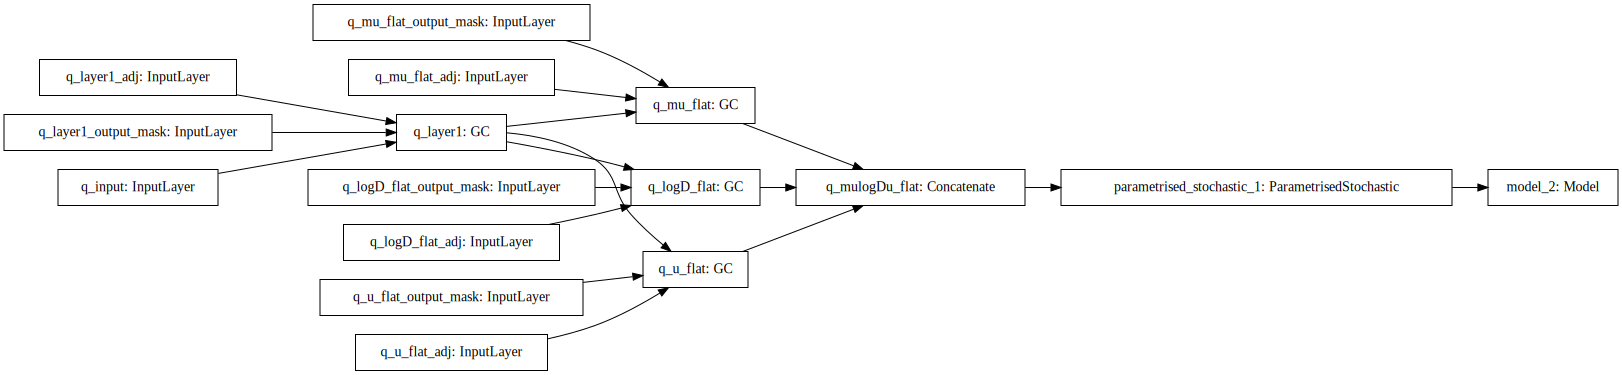

model_2


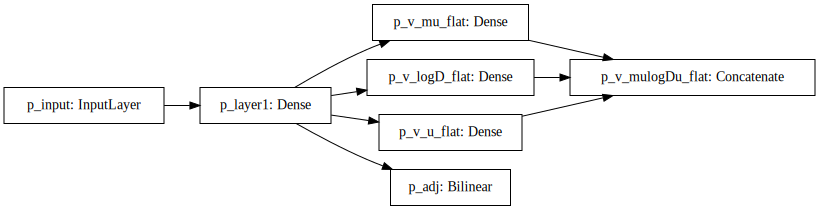

In [6]:
print('Overall model')
display(SVG(model_to_dot(vae, rankdir='LR').create(prog='dot', format='svg')))

for layer in vae.layers:
    if not isinstance(layer, keras.Model):
        continue
    print(layer.name)
    display(SVG(model_to_dot(layer, rankdir='LR').create(prog='dot', format='svg')))

## Batches generator

In [7]:
def batches(model, features, adj, batch_size, max_walk_length, neighbour_samples=None):
    features = utils.scale_center(features)
    
    while True:
        for needed_nodes, output_nodes, feeds in batching.epoch_batches(model, adj, batch_size, max_walk_length, neighbour_samples):
            batch_adj = adj[output_nodes, :][:, output_nodes]

            x = features[needed_nodes]
            y = [
                np.zeros(1), # ignored
                utils.expand_dims_tile(utils.expand_dims_tile(batch_adj + np.eye(batch_adj.shape[0]), 0, n_ξ_samples), 0, 1),
                utils.expand_dims_tile(features[output_nodes], 1, n_ξ_samples),
            ]
            
            yield x, y, feeds

## Before training

$\xi$ averages and distributions for each community, real and predicted adjacency matrices

In [ ]:
plot_ξ_distribution(g, q_model, adj, labels, batches)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

x, _, feeds = next(batches(vae, features, adj, adj.shape[0], adj.shape[0], None))
adj_pred = vae.predict_on_fed_batch(x, feeds=feeds)[1]
im2 = ax2.imshow(scipy.special.expit(adj_pred[0].mean(axis=0)))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

## Train

In [8]:
rm -r ./logs

rm: cannot remove './logs': No such file or directory


In [13]:
time.sleep(5)

In [ ]:
n_epochs = 5000
batch_size = 500 #len(features)
max_walk_length = 200

vae.fit_generator_feed(batches(vae, labels, adj, batch_size, max_walk_length, neighbour_samples=None),
                       steps_per_epoch=int(np.ceil(len(labels) / batch_size)),
                       epochs=n_epochs,
                       check_array_lengths=False,
                       shuffle=False,
                       verbose=0,
                       callbacks=[
                           keras.callbacks.TensorBoard()
                       ])

/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Usually, the cell above complains with "UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.". See these for more details:
* https://stackoverflow.com/questions/35892412/tensorflow-dense-gradient-explanation#35896823
* https://stackoverflow.com/questions/39111373/tensorflow-chaining-tf-gather-produces-indexedslices-warning

## Results

**After training:** $\xi$ averages and distributions for each community, real and predicted adjacency matrices

In [ ]:
plot_ξ_distribution((g, l, k), q_model, adj, features, batches)

Predicted adjacency matrix:

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

x, _, feeds = next(batches(vae, features, adj, adj.shape[0], adj.shape[0], None))
adj_pred = vae.predict_on_fed_batch(x, feeds=feeds)[1]
im2 = ax2.imshow(scipy.special.expit(adj_pred[0].mean(axis=0)))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

In [ ]:
plt.imshow(np.random.binomial(1, scipy.special.expit(adj_pred[0].mean(axis=0))))

In [ ]:
for layer in q_model.layers:
    if hasattr(layer, 'kernel'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))#, sharey=True)
        im1 = ax1.imshow(K.eval(layer.kernel).T)
        ax1.set_title('{} kernel'.format(layer.name))
        plt.colorbar(im1, ax=ax1)
    if hasattr(layer, 'bias') and layer.bias is not None:
        im2 = ax2.imshow(K.eval(K.expand_dims(layer.bias, -1)))
        ax2.set_title('{} bias'.format(layer.name))
        plt.colorbar(im2, ax=ax2)

In [ ]:
for layer in p_model.layers:
    if hasattr(layer, 'kernel'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))#, sharey=True)
        im1 = ax1.imshow(K.eval(layer.kernel).T)
        ax1.set_title('{} kernel'.format(layer.name))
        plt.colorbar(im1, ax=ax1)
    if hasattr(layer, 'bias') and layer.bias is not None:
        im2 = ax2.imshow(K.eval(K.expand_dims(layer.bias, -1)))
        ax2.set_title('{} bias'.format(layer.name))
        plt.colorbar(im2, ax=ax2)